In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

import dask.dataframe as dd

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, DC_COLOR_MAPPINGS, FREQ_GROUPS
from cli import get_file_paths

import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh
import plotting
import pipeline

In [4]:
type_key = 'LF1'
site_key = "Foliage"
# cycle_lengths = [1800, 720, 600, 360, 180, 60, 30, 6]
cycle_lengths = [1800, 360]
percent_ons = [0.1667]
specific_dc_tag = "1800of1800"

In [5]:
fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]

In [6]:
pipeline_params = dict()
pipeline_params['assemble_location_summary'] = False
pipeline_params["read_csv"] = False
pipeline_params["save_activity_grid"] = True
pipeline_params["save_presence_grid"] = True
pipeline_params["save_dc_night_comparisons"] = True
pipeline_params["save_activity_dc_comparisons"] = True
pipeline_params["save_presence_dc_comparisons"] = True
pipeline_params["show_plots"] = False
pipeline_params["show_PST"] = True
pipeline_params

{'assemble_location_summary': False,
 'read_csv': False,
 'save_activity_grid': True,
 'save_presence_grid': True,
 'save_dc_night_comparisons': True,
 'save_activity_dc_comparisons': True,
 'save_presence_dc_comparisons': True,
 'show_plots': False,
 'show_PST': True}

In [7]:
data_params = dict()
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = type_key
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['resolution_in_min'] = '30'
data_params['recording_start'] = '02:00'
data_params['recording_end'] = '13:30'
data_params

{'site_name': 'Foliage',
 'site_tag': 'Foliage',
 'type_tag': 'LF1',
 'cycle_lengths': [1800, 360],
 'percent_ons': [0.1667],
 'dc_tags': ['1800of1800', '300of1800', '60of360'],
 'cur_dc_tag': '1800of1800',
 'resolution_in_min': '30',
 'recording_start': '02:00',
 'recording_end': '13:30'}

In [8]:
file_paths = get_file_paths(data_params)
file_paths

{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Foliage',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Foliage',
 'bd2_TYPE_SITE_YEAR': 'bd2__LF1Foliage_2022',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Foliage/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_dets_LF1Foliage_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_bouts_LF1Foliage_summary',
 'dc_inds_TYPE_SITE_summary': 'dc_inds_LF1Foliage_summary',
 'simulated_schemes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Foliage/duty_cycled/simulated_schemes',
 'figures_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../figures/Foliage',
 'activity_det_comparisons_figname': 'activity_det_comparisons_per_dc_LF1Foliage',
 'dc_det_comparisons_figname': 'dc_det_comparisons_per_night_LF1Foliage',
 'activity_bout_comparisons_figname': 'activity_bout_comp

In [9]:
groups = FREQ_GROUPS[data_params['site_tag']]
blue_group = groups['blue']
red_group = groups['red']
yellow_group = groups['yellow']

location_df = dd.read_csv(f'{file_paths["raw_SITE_folder"]}/*.csv').compute()
location_df[:4]

start_time  end_time low_freq high_freq         event  \
0   204.4695  204.4856  18593.0   23399.0  Echolocation   
0   145.1915  145.1971  41796.0   61385.0  Echolocation   
1   145.6255  145.6325  40937.0   63845.0  Echolocation   
2   145.7975  145.8038  41796.0   61714.0  Echolocation   

                   class class_prob det_prob individual  \
0       Nyctalus noctula      0.399    0.544         -1   
0  Pipistrellus nathusii      0.364    0.512         -1   
1  Pipistrellus nathusii      0.488    0.543         -1   
2  Pipistrellus nathusii      0.473    0.513         -1   

                                          input_file Site name  \
0  /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
0  /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
1  /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
2  /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   

           Recover Folder SD Card  
0  recover-20220616_unit2      10  
0  recover-20220616_unit2      10  
1  recover-20220616_unit2      10  
2  recover-20220616_unit2      10

In [10]:
location_df['low_freq'] = location_df['low_freq'].astype('float')
location_df['high_freq'] = location_df['high_freq'].astype('float')
file_dts = pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S', exact=False)
file_dts

0    2022-06-15 03:30:00
0    2022-06-15 04:30:00
1    2022-06-15 04:30:00
2    2022-06-15 04:30:00
3    2022-06-15 04:30:00
             ...        
8    2022-10-17 08:30:00
9    2022-10-17 08:30:00
10   2022-10-17 08:30:00
11   2022-10-17 08:30:00
0    2022-10-17 10:00:00
Name: input_file, Length: 644243, dtype: datetime64[ns]

In [11]:
location_df[:4]

start_time  end_time  low_freq  high_freq         event  \
0   204.4695  204.4856   18593.0    23399.0  Echolocation   
0   145.1915  145.1971   41796.0    61385.0  Echolocation   
1   145.6255  145.6325   40937.0    63845.0  Echolocation   
2   145.7975  145.8038   41796.0    61714.0  Echolocation   

                   class class_prob det_prob individual  \
0       Nyctalus noctula      0.399    0.544         -1   
0  Pipistrellus nathusii      0.364    0.512         -1   
1  Pipistrellus nathusii      0.488    0.543         -1   
2  Pipistrellus nathusii      0.473    0.513         -1   

                                          input_file Site name  \
0  /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
0  /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
1  /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
2  /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   

           Recover Folder SD Card  
0  recover-20220616_unit2      10  
0  recover-20220616_unit2      10  
1  recover-20220616_unit2      10  
2  recover-20220616_unit2      10

In [12]:
anchor_start_times = file_dts + pd.to_timedelta(location_df['start_time'].values.astype('float64'), unit='S')
anchor_end_times = file_dts + pd.to_timedelta(location_df['end_time'].values.astype('float64'), unit='S')

location_df.insert(0, 'call_end_time', anchor_end_times)
location_df.insert(0, 'call_start_time', anchor_start_times)
location_df.insert(0, 'ref_time', anchor_start_times)
location_df.insert(0, 'freq_group', '')
location_df

freq_group                   ref_time            call_start_time  \
0             2022-06-15 03:33:24.469500 2022-06-15 03:33:24.469500   
0             2022-06-15 04:32:25.191500 2022-06-15 04:32:25.191500   
1             2022-06-15 04:32:25.625500 2022-06-15 04:32:25.625500   
2             2022-06-15 04:32:25.797500 2022-06-15 04:32:25.797500   
3             2022-06-15 04:32:26.110500 2022-06-15 04:32:26.110500   
..        ...                        ...                        ...   
8             2022-10-17 08:32:30.991500 2022-10-17 08:32:30.991500   
9             2022-10-17 08:32:31.083500 2022-10-17 08:32:31.083500   
10            2022-10-17 08:32:31.488500 2022-10-17 08:32:31.488500   
11            2022-10-17 08:32:32.354500 2022-10-17 08:32:32.354500   
0             2022-10-17 10:21:52.593500 2022-10-17 10:21:52.593500   

                call_end_time start_time   end_time  low_freq  high_freq  \
0  2022-06-15 03:33:24.485600   204.4695   204.4856   18593.0    23399.0   
0  2022-06-15 04:32:25.197100   145.1915   145.1971   41796.0    61385.0   
1  2022-06-15 04:32:25.632500   145.6255   145.6325   40937.0    63845.0   
2  2022-06-15 04:32:25.803800   145.7975   145.8038   41796.0    61714.0   
3  2022-06-15 04:32:26.115800   146.1105   146.1158   35781.0    62458.0   
..                        ...        ...        ...       ...        ...   
8  2022-10-17 08:32:31.003700   150.9915   151.0037   44375.0    55330.0   
9  2022-10-17 08:32:31.095200   151.0835   151.0952   45234.0    62435.0   
10 2022-10-17 08:32:31.494600   151.4885   151.4946   45234.0    55595.0   
11 2022-10-17 08:32:32.360600   152.3545   152.3606   46953.0    61784.0   
0  2022-10-17 10:21:52.600200  1312.5935  1312.6002   46953.0    57745.0   

           event                      class class_prob det_prob individual  \
0   Echolocation           Nyctalus noctula      0.399    0.544         -1   
0   Echolocation      Pipistrellus nathusii      0.364    0.512         -1   
1   Echolocation      Pipistrellus nathusii      0.488    0.543         -1   
2   Echolocation      Pipistrellus nathusii      0.473    0.513         -1   
3   Echolocation            Myotis brandtii      0.381      0.6         -1   
..           ...                        ...        ...      ...        ...   
8   Echolocation  Pipistrellus pipistrellus      0.436    0.526         -1   
9   Echolocation  Pipistrellus pipistrellus      0.463    0.548         -1   
10  Echolocation  Pipistrellus pipistrellus      0.612    0.637         -1   
11  Echolocation  Pipistrellus pipistrellus      0.389    0.505         -1   
0   Echolocation  Pipistrellus pipistrellus      0.494    0.533         -1   

                                           input_file Site name  \
0   /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
0   /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
1   /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
2   /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
3   /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
..                                                ...       ...   
8   /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
9   /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
10  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
11  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
0   /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   

            Recover Folder SD Card  
0   recover-20220616_unit2      10  
0   recover-20220616_unit2      10  
1   recover-20220616_unit2      10  
2   recover-20220616_unit2      10  
3   recover-20220616_unit2      10  
..                     ...     ...  
8         recover-20221017       8  
9         recover-20221017       8  
10        recover-20221017       8  
11        recover-20221017       8  
0         recover-20221017       8  

[644243 rows x 17 columns]

In [13]:
call_is_yellow = (location_df['low_freq']>=yellow_group[0])&(location_df['high_freq']<=yellow_group[1])
location_df.loc[call_is_yellow, 'freq_group'] = 'HF2'
location_df.loc[call_is_yellow][:40]

freq_group                      ref_time               call_start_time  \
8         HF2 2022-06-15 04:32:31.517499999 2022-06-15 04:32:31.517499999   
15        HF2 2022-06-15 04:32:47.924500000 2022-06-15 04:32:47.924500000   
31        HF2 2022-06-15 04:34:17.526499999 2022-06-15 04:34:17.526499999   
33        HF2 2022-06-15 04:34:18.041500000 2022-06-15 04:34:18.041500000   
34        HF2 2022-06-15 04:34:18.742500000 2022-06-15 04:34:18.742500000   
35        HF2 2022-06-15 04:34:19.581500000 2022-06-15 04:34:19.581500000   
36        HF2 2022-06-15 04:34:19.633500000 2022-06-15 04:34:19.633500000   
37        HF2 2022-06-15 04:34:19.692500000 2022-06-15 04:34:19.692500000   
38        HF2 2022-06-15 04:34:19.742500000 2022-06-15 04:34:19.742500000   
39        HF2 2022-06-15 04:34:19.790500000 2022-06-15 04:34:19.790500000   
40        HF2 2022-06-15 04:34:19.858500000 2022-06-15 04:34:19.858500000   
41        HF2 2022-06-15 04:34:19.986500000 2022-06-15 04:34:19.986500000   
42        HF2 2022-06-15 04:34:20.079500000 2022-06-15 04:34:20.079500000   
43        HF2 2022-06-15 04:34:20.149500000 2022-06-15 04:34:20.149500000   
44        HF2 2022-06-15 04:34:20.222500000 2022-06-15 04:34:20.222500000   
45        HF2 2022-06-15 04:34:20.286500000 2022-06-15 04:34:20.286500000   
48        HF2 2022-06-15 04:34:23.595500000 2022-06-15 04:34:23.595500000   
49        HF2 2022-06-15 04:34:25.563500000 2022-06-15 04:34:25.563500000   
60        HF2 2022-06-15 04:34:33.221500000 2022-06-15 04:34:33.221500000   
67        HF2 2022-06-15 04:35:04.040500000 2022-06-15 04:35:04.040500000   
68        HF2 2022-06-15 04:35:04.271500000 2022-06-15 04:35:04.271500000   
69        HF2 2022-06-15 04:35:04.475500000 2022-06-15 04:35:04.475500000   
70        HF2 2022-06-15 04:35:04.799500000 2022-06-15 04:35:04.799500000   
71        HF2 2022-06-15 04:35:05.134500000 2022-06-15 04:35:05.134500000   
72        HF2 2022-06-15 04:35:05.378500000 2022-06-15 04:35:05.378500000   
73        HF2 2022-06-15 04:35:05.566500000 2022-06-15 04:35:05.566500000   
74        HF2 2022-06-15 04:35:05.883500000 2022-06-15 04:35:05.883500000   
75        HF2 2022-06-15 04:35:07.076500000 2022-06-15 04:35:07.076500000   
80        HF2 2022-06-15 04:35:13.971500000 2022-06-15 04:35:13.971500000   
81        HF2 2022-06-15 04:35:42.749500000 2022-06-15 04:35:42.749500000   
82        HF2 2022-06-15 04:35:42.921500000 2022-06-15 04:35:42.921500000   
83        HF2 2022-06-15 04:35:43.271500000 2022-06-15 04:35:43.271500000   
84        HF2 2022-06-15 04:35:43.348500000 2022-06-15 04:35:43.348500000   
85        HF2 2022-06-15 04:35:43.507499999 2022-06-15 04:35:43.507499999   
86        HF2 2022-06-15 04:35:43.657500000 2022-06-15 04:35:43.657500000   
87        HF2 2022-06-15 04:35:43.742500000 2022-06-15 04:35:43.742500000   
88        HF2 2022-06-15 04:35:43.814500000 2022-06-15 04:35:43.814500000   
89        HF2 2022-06-15 04:35:44.390500000 2022-06-15 04:35:44.390500000   
90        HF2 2022-06-15 04:35:44.442500000 2022-06-15 04:35:44.442500000   
91        HF2 2022-06-15 04:35:44.785500000 2022-06-15 04:35:44.785500000   

                call_end_time start_time  end_time  low_freq  high_freq  \
8  2022-06-15 04:32:31.524300   151.5175  151.5243   42656.0    58356.0   
15 2022-06-15 04:32:47.932600   167.9245  167.9326   44375.0    57192.0   
31 2022-06-15 04:34:17.531300   257.5265  257.5313   42656.0    80523.0   
33 2022-06-15 04:34:18.044900   258.0415  258.0449   45234.0    69242.0   
34 2022-06-15 04:34:18.746200   258.7425  258.7462   43515.0    68548.0   
35 2022-06-15 04:34:19.585400   259.5815  259.5854   52109.0    71827.0   
36 2022-06-15 04:34:19.636400   259.6335  259.6364   47812.0    69522.0   
37 2022-06-15 04:34:19.695900   259.6925  259.6959   52109.0    76024.0   
38 2022-06-15 04:34:19.745300   259.7425  259.7453   52109.0    71722.0   
39 2022-06-15 04:34:19.793500   259.7905  259.7935   50390.0    73902.0   
40 2022-06-15 04:34:

In [14]:
call_is_red = (location_df['low_freq']>=red_group[0])&(location_df['high_freq']<=red_group[1])
location_df.loc[call_is_red&(~(call_is_yellow)), 'freq_group'] = 'HF1'
location_df.loc[call_is_red&(~(call_is_yellow))]

freq_group                   ref_time            call_start_time  \
0          HF1 2022-06-15 04:32:25.191500 2022-06-15 04:32:25.191500   
1          HF1 2022-06-15 04:32:25.625500 2022-06-15 04:32:25.625500   
2          HF1 2022-06-15 04:32:25.797500 2022-06-15 04:32:25.797500   
3          HF1 2022-06-15 04:32:26.110500 2022-06-15 04:32:26.110500   
4          HF1 2022-06-15 04:32:26.191500 2022-06-15 04:32:26.191500   
..         ...                        ...                        ...   
305        HF1 2022-10-17 07:57:40.152500 2022-10-17 07:57:40.152500   
306        HF1 2022-10-17 07:57:40.244500 2022-10-17 07:57:40.244500   
307        HF1 2022-10-17 07:57:40.398500 2022-10-17 07:57:40.398500   
309        HF1 2022-10-17 07:57:40.573500 2022-10-17 07:57:40.573500   
331        HF1 2022-10-17 07:58:51.744500 2022-10-17 07:58:51.744500   

                 call_end_time start_time   end_time  low_freq  high_freq  \
0   2022-06-15 04:32:25.197100   145.1915   145.1971   41796.0    61385.0   
1   2022-06-15 04:32:25.632500   145.6255   145.6325   40937.0    63845.0   
2   2022-06-15 04:32:25.803800   145.7975   145.8038   41796.0    61714.0   
3   2022-06-15 04:32:26.115800   146.1105   146.1158   35781.0    62458.0   
4   2022-06-15 04:32:26.198000   146.1915    146.198   39218.0    66775.0   
..                         ...        ...        ...       ...        ...   
305 2022-10-17 07:57:40.160700  1660.1525  1660.1607   41796.0    62258.0   
306 2022-10-17 07:57:40.250300  1660.2445  1660.2503   41796.0    62638.0   
307 2022-10-17 07:57:40.403700  1660.3985  1660.4037   41796.0    63494.0   
309 2022-10-17 07:57:40.579700  1660.5735  1660.5797   40937.0    72461.0   
331 2022-10-17 07:58:51.750400  1731.7445  1731.7504   41796.0    63061.0   

            event                      class class_prob det_prob individual  \
0    Echolocation      Pipistrellus nathusii      0.364    0.512         -1   
1    Echolocation      Pipistrellus nathusii      0.488    0.543         -1   
2    Echolocation      Pipistrellus nathusii      0.473    0.513         -1   
3    Echolocation            Myotis brandtii      0.381      0.6         -1   
4    Echolocation      Pipistrellus nathusii      0.193    0.526         -1   
..            ...                        ...        ...      ...        ...   
305  Echolocation  Pipistrellus pipistrellus      0.249    0.577         -1   
306  Echolocation  Pipistrellus pipistrellus      0.383    0.621         -1   
307  Echolocation  Pipistrellus pipistrellus      0.465    0.637         -1   
309  Echolocation  Pipistrellus pipistrellus       0.26    0.511         -1   
331  Echolocation  Pipistrellus pipistrellus      0.158     0.55         -1   

                                            input_file Site name  \
0    /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
1    /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
2    /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
3    /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
4    /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
..                                                 ...       ...   
305  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
306  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
307  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
309  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
331  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   

             Recover Folder SD Card  
0    recover-20220616_unit2      10  
1    recover-20220616_unit2      10  
2    recover-20220616_unit2      10  
3    recover-20220616_unit2      10  
4    recover-20220616_unit2      10  
..                      ...     ...  
305        recover-20221017       8  
306        recover-20221017       8  
307        recover-20221017       8  
309        recover-20221017       8  
331        recover-20221017   

In [15]:
call_is_blue = (location_df['low_freq']>=blue_group[0])&(location_df['high_freq']<=blue_group[1])

location_df.loc[call_is_blue&(~(call_is_red | call_is_yellow)), 'freq_group'] = 'LF1'
location_df.loc[call_is_blue&(~(call_is_red | call_is_yellow))]

freq_group                   ref_time            call_start_time  \
0          LF1 2022-06-15 03:33:24.469500 2022-06-15 03:33:24.469500   
338        LF1 2022-06-15 04:42:22.783500 2022-06-15 04:42:22.783500   
339        LF1 2022-06-15 04:42:24.231500 2022-06-15 04:42:24.231500   
340        LF1 2022-06-15 04:42:24.705500 2022-06-15 04:42:24.705500   
357        LF1 2022-06-15 04:43:05.575500 2022-06-15 04:43:05.575500   
..         ...                        ...                        ...   
12         LF1 2022-10-17 08:00:51.110500 2022-10-17 08:00:51.110500   
13         LF1 2022-10-17 08:00:51.336500 2022-10-17 08:00:51.336500   
14         LF1 2022-10-17 08:00:51.550500 2022-10-17 08:00:51.550500   
15         LF1 2022-10-17 08:00:51.778500 2022-10-17 08:00:51.778500   
16         LF1 2022-10-17 08:00:52.248500 2022-10-17 08:00:52.248500   

                 call_end_time start_time            end_time  low_freq  \
0   2022-06-15 03:33:24.485600   204.4695            204.4856   18593.0   
338 2022-06-15 04:42:22.799900   742.7835            742.7999   22890.0   
339 2022-06-15 04:42:24.246800   744.2315            744.2468   22890.0   
340 2022-06-15 04:42:24.721700   744.7055            744.7217   22890.0   
357 2022-06-15 04:43:05.591400   785.5755            785.5914   24609.0   
..                         ...        ...                 ...       ...   
12  2022-10-17 08:00:51.125300    51.1105             51.1253   26328.0   
13  2022-10-17 08:00:51.351600    51.3365  51.351600000000005   26328.0   
14  2022-10-17 08:00:51.565000    51.5505              51.565   25468.0   
15  2022-10-17 08:00:51.793700    51.7785             51.7937   25468.0   
16  2022-10-17 08:00:52.263500    52.2485             52.2635   25468.0   

     high_freq         event              class class_prob det_prob  \
0      23399.0  Echolocation   Nyctalus noctula      0.399    0.544   
338    26704.0  Echolocation  Nyctalus leisleri       0.52      0.6   
339    28244.0  Echolocation  Nyctalus leisleri      0.555     0.66   
340    28061.0  Echolocation  Nyctalus leisleri      0.471    0.601   
357    29948.0  Echolocation  Nyctalus leisleri      0.328     0.53   
..         ...           ...                ...        ...      ...   
12     30370.0  Echolocation  Nyctalus leisleri       0.46    0.557   
13     29379.0  Echolocation  Nyctalus leisleri      0.543    0.608   
14     30578.0  Echolocation  Nyctalus leisleri      0.388    0.556   
15     29126.0  Echolocation  Nyctalus leisleri      0.529    0.607   
16     29590.0  Echolocation  Nyctalus leisleri      0.486      0.6   

    individual                                         input_file Site name  \
0           -1  /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
338         -1  /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
339         -1  /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
340         -1  /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
357         -1  /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
..         ...                                                ...       ...   
12          -1  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
13          -1  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
14          -1  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
15          -1  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
16          -1  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   

             Recover Folder SD Card  
0    recover-20220616_unit2      10  
338  recover-20220616_unit2      10  
339  recover-20220616_unit2      10  
340  recover-20220616_unit2      10  
357  recover-20220616_unit2      10  
..                      ...     ...  
12         recover-20221017       8  
13         recover-20221017       8  
14         recover-20221017       8  
15         recover-20221017       8  
16         recover

In [16]:
location_df

freq_group                   ref_time            call_start_time  \
0         LF1 2022-06-15 03:33:24.469500 2022-06-15 03:33:24.469500   
0         HF1 2022-06-15 04:32:25.191500 2022-06-15 04:32:25.191500   
1         HF1 2022-06-15 04:32:25.625500 2022-06-15 04:32:25.625500   
2         HF1 2022-06-15 04:32:25.797500 2022-06-15 04:32:25.797500   
3         HF1 2022-06-15 04:32:26.110500 2022-06-15 04:32:26.110500   
..        ...                        ...                        ...   
8         HF2 2022-10-17 08:32:30.991500 2022-10-17 08:32:30.991500   
9         HF2 2022-10-17 08:32:31.083500 2022-10-17 08:32:31.083500   
10        HF2 2022-10-17 08:32:31.488500 2022-10-17 08:32:31.488500   
11        HF2 2022-10-17 08:32:32.354500 2022-10-17 08:32:32.354500   
0         HF2 2022-10-17 10:21:52.593500 2022-10-17 10:21:52.593500   

                call_end_time start_time   end_time  low_freq  high_freq  \
0  2022-06-15 03:33:24.485600   204.4695   204.4856   18593.0    23399.0   
0  2022-06-15 04:32:25.197100   145.1915   145.1971   41796.0    61385.0   
1  2022-06-15 04:32:25.632500   145.6255   145.6325   40937.0    63845.0   
2  2022-06-15 04:32:25.803800   145.7975   145.8038   41796.0    61714.0   
3  2022-06-15 04:32:26.115800   146.1105   146.1158   35781.0    62458.0   
..                        ...        ...        ...       ...        ...   
8  2022-10-17 08:32:31.003700   150.9915   151.0037   44375.0    55330.0   
9  2022-10-17 08:32:31.095200   151.0835   151.0952   45234.0    62435.0   
10 2022-10-17 08:32:31.494600   151.4885   151.4946   45234.0    55595.0   
11 2022-10-17 08:32:32.360600   152.3545   152.3606   46953.0    61784.0   
0  2022-10-17 10:21:52.600200  1312.5935  1312.6002   46953.0    57745.0   

           event                      class class_prob det_prob individual  \
0   Echolocation           Nyctalus noctula      0.399    0.544         -1   
0   Echolocation      Pipistrellus nathusii      0.364    0.512         -1   
1   Echolocation      Pipistrellus nathusii      0.488    0.543         -1   
2   Echolocation      Pipistrellus nathusii      0.473    0.513         -1   
3   Echolocation            Myotis brandtii      0.381      0.6         -1   
..           ...                        ...        ...      ...        ...   
8   Echolocation  Pipistrellus pipistrellus      0.436    0.526         -1   
9   Echolocation  Pipistrellus pipistrellus      0.463    0.548         -1   
10  Echolocation  Pipistrellus pipistrellus      0.612    0.637         -1   
11  Echolocation  Pipistrellus pipistrellus      0.389    0.505         -1   
0   Echolocation  Pipistrellus pipistrellus      0.494    0.533         -1   

                                           input_file Site name  \
0   /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
0   /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
1   /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
2   /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
3   /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
..                                                ...       ...   
8   /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
9   /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
10  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
11  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
0   /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   

            Recover Folder SD Card  
0   recover-20220616_unit2      10  
0   recover-20220616_unit2      10  
1   recover-20220616_unit2      10  
2   recover-20220616_unit2      10  
3   recover-20220616_unit2      10  
..                     ...     ...  
8         recover-20221017       8  
9         recover-20221017       8  
10        recover-20221017       8  
11        recover-20221017       8  
0         recover-20221017       8  

[644243 rows x 17 columns]

In [17]:
initial_location_df = dh.assemble_initial_location_summary(data_params, file_paths, save=False)

In [18]:
activity_bouts_arr = pd.DataFrame()

# for dc_tag in data_params['dc_tags']:
dc_tag = data_params['dc_tags'][0]
print(dc_tag)
location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag)
location_df

1800of1800


start_time_wrt_ref  end_time_wrt_ref freq_group            ref_time  \
0              204.4695          204.4856        LF1 2022-06-15 03:30:00   
338            742.7835          742.7999        LF1 2022-06-15 04:30:00   
339            744.2315          744.2468        LF1 2022-06-15 04:30:00   
340            744.7055          744.7217        LF1 2022-06-15 04:30:00   
357            785.5755          785.5914        LF1 2022-06-15 04:30:00   
..                  ...               ...        ...                 ...   
12              51.1105           51.1253        LF1 2022-10-17 08:00:00   
13              51.3365           51.3516        LF1 2022-10-17 08:00:00   
14              51.5505           51.5650        LF1 2022-10-17 08:00:00   
15              51.7785           51.7937        LF1 2022-10-17 08:00:00   
16              52.2485           52.2635        LF1 2022-10-17 08:00:00   

               call_start_time              call_end_time  start_time  \
0   2022-06-15 03:33:24.469500 2022-06-15 03:33:24.485600    204.4695   
338 2022-06-15 04:42:22.783500 2022-06-15 04:42:22.799900    742.7835   
339 2022-06-15 04:42:24.231500 2022-06-15 04:42:24.246800    744.2315   
340 2022-06-15 04:42:24.705500 2022-06-15 04:42:24.721700    744.7055   
357 2022-06-15 04:43:05.575500 2022-06-15 04:43:05.591400    785.5755   
..                         ...                        ...         ...   
12  2022-10-17 08:00:51.110500 2022-10-17 08:00:51.125300     51.1105   
13  2022-10-17 08:00:51.336500 2022-10-17 08:00:51.351600     51.3365   
14  2022-10-17 08:00:51.550500 2022-10-17 08:00:51.565000     51.5505   
15  2022-10-17 08:00:51.778500 2022-10-17 08:00:51.793700     51.7785   
16  2022-10-17 08:00:52.248500 2022-10-17 08:00:52.263500     52.2485   

     end_time  low_freq  high_freq         event              class  \
0    204.4856   18593.0    23399.0  Echolocation   Nyctalus noctula   
338  742.7999   22890.0    26704.0  Echolocation  Nyctalus leisleri   
339  744.2468   22890.0    28244.0  Echolocation  Nyctalus leisleri   
340  744.7217   22890.0    28061.0  Echolocation  Nyctalus leisleri   
357  785.5914   24609.0    29948.0  Echolocation  Nyctalus leisleri   
..        ...       ...        ...           ...                ...   
12    51.1253   26328.0    30370.0  Echolocation  Nyctalus leisleri   
13    51.3516   26328.0    29379.0  Echolocation  Nyctalus leisleri   
14    51.5650   25468.0    30578.0  Echolocation  Nyctalus leisleri   
15    51.7937   25468.0    29126.0  Echolocation  Nyctalus leisleri   
16    52.2635   25468.0    29590.0  Echolocation  Nyctalus leisleri   

     class_prob  det_prob  individual  \
0         0.399     0.544          -1   
338       0.520     0.600          -1   
339       0.555     0.660          -1   
340       0.471     0.601          -1   
357       0.328     0.530          -1   
..          ...       ...         ...   
12        0.460     0.557          -1   
13        0.543     0.608          -1   
14        0.388     0.556          -1   
15        0.529     0.607          -1   
16        0.486     0.600          -1   

                                            input_file Site name  \
0    /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
338  /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
339  /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
340  /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
357  /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
..                                                 ...       ...   
12   /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
13   /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
14   /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
15   /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
16   /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   

             Recover Folder SD Card  
0    recover-2

In [19]:
location_sum_df = location_df.copy()
location_sum_df.reset_index(inplace=True)
location_sum_df

index  start_time_wrt_ref  end_time_wrt_ref freq_group  \
0           0            204.4695          204.4856        LF1   
1         338            742.7835          742.7999        LF1   
2         339            744.2315          744.2468        LF1   
3         340            744.7055          744.7217        LF1   
4         357            785.5755          785.5914        LF1   
...       ...                 ...               ...        ...   
168872     12             51.1105           51.1253        LF1   
168873     13             51.3365           51.3516        LF1   
168874     14             51.5505           51.5650        LF1   
168875     15             51.7785           51.7937        LF1   
168876     16             52.2485           52.2635        LF1   

                  ref_time            call_start_time  \
0      2022-06-15 03:30:00 2022-06-15 03:33:24.469500   
1      2022-06-15 04:30:00 2022-06-15 04:42:22.783500   
2      2022-06-15 04:30:00 2022-06-15 04:42:24.231500   
3      2022-06-15 04:30:00 2022-06-15 04:42:24.705500   
4      2022-06-15 04:30:00 2022-06-15 04:43:05.575500   
...                    ...                        ...   
168872 2022-10-17 08:00:00 2022-10-17 08:00:51.110500   
168873 2022-10-17 08:00:00 2022-10-17 08:00:51.336500   
168874 2022-10-17 08:00:00 2022-10-17 08:00:51.550500   
168875 2022-10-17 08:00:00 2022-10-17 08:00:51.778500   
168876 2022-10-17 08:00:00 2022-10-17 08:00:52.248500   

                    call_end_time  start_time  end_time  low_freq  high_freq  \
0      2022-06-15 03:33:24.485600    204.4695  204.4856   18593.0    23399.0   
1      2022-06-15 04:42:22.799900    742.7835  742.7999   22890.0    26704.0   
2      2022-06-15 04:42:24.246800    744.2315  744.2468   22890.0    28244.0   
3      2022-06-15 04:42:24.721700    744.7055  744.7217   22890.0    28061.0   
4      2022-06-15 04:43:05.591400    785.5755  785.5914   24609.0    29948.0   
...                           ...         ...       ...       ...        ...   
168872 2022-10-17 08:00:51.125300     51.1105   51.1253   26328.0    30370.0   
168873 2022-10-17 08:00:51.351600     51.3365   51.3516   26328.0    29379.0   
168874 2022-10-17 08:00:51.565000     51.5505   51.5650   25468.0    30578.0   
168875 2022-10-17 08:00:51.793700     51.7785   51.7937   25468.0    29126.0   
168876 2022-10-17 08:00:52.263500     52.2485   52.2635   25468.0    29590.0   

               event              class  class_prob  det_prob  individual  \
0       Echolocation   Nyctalus noctula       0.399     0.544          -1   
1       Echolocation  Nyctalus leisleri       0.520     0.600          -1   
2       Echolocation  Nyctalus leisleri       0.555     0.660          -1   
3       Echolocation  Nyctalus leisleri       0.471     0.601          -1   
4       Echolocation  Nyctalus leisleri       0.328     0.530          -1   
...              ...                ...         ...       ...         ...   
168872  Echolocation  Nyctalus leisleri       0.460     0.557          -1   
168873  Echolocation  Nyctalus leisleri       0.543     0.608          -1   
168874  Echolocation  Nyctalus leisleri       0.388     0.556          -1   
168875  Echolocation  Nyctalus leisleri       0.529     0.607          -1   
168876  Echolocation  Nyctalus leisleri       0.486     0.600          -1   

                                               input_file Site name  \
0       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
1       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
2       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
3       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
4       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
...                                                   ...       ...   
168872  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
168873  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
16887

In [20]:
if 'index' in location_sum_df.columns:
    location_sum_df.drop(columns='index', inplace=True)
location_sum_df

start_time_wrt_ref  end_time_wrt_ref freq_group            ref_time  \
0                 204.4695          204.4856        LF1 2022-06-15 03:30:00   
1                 742.7835          742.7999        LF1 2022-06-15 04:30:00   
2                 744.2315          744.2468        LF1 2022-06-15 04:30:00   
3                 744.7055          744.7217        LF1 2022-06-15 04:30:00   
4                 785.5755          785.5914        LF1 2022-06-15 04:30:00   
...                    ...               ...        ...                 ...   
168872             51.1105           51.1253        LF1 2022-10-17 08:00:00   
168873             51.3365           51.3516        LF1 2022-10-17 08:00:00   
168874             51.5505           51.5650        LF1 2022-10-17 08:00:00   
168875             51.7785           51.7937        LF1 2022-10-17 08:00:00   
168876             52.2485           52.2635        LF1 2022-10-17 08:00:00   

                  call_start_time              call_end_time  start_time  \
0      2022-06-15 03:33:24.469500 2022-06-15 03:33:24.485600    204.4695   
1      2022-06-15 04:42:22.783500 2022-06-15 04:42:22.799900    742.7835   
2      2022-06-15 04:42:24.231500 2022-06-15 04:42:24.246800    744.2315   
3      2022-06-15 04:42:24.705500 2022-06-15 04:42:24.721700    744.7055   
4      2022-06-15 04:43:05.575500 2022-06-15 04:43:05.591400    785.5755   
...                           ...                        ...         ...   
168872 2022-10-17 08:00:51.110500 2022-10-17 08:00:51.125300     51.1105   
168873 2022-10-17 08:00:51.336500 2022-10-17 08:00:51.351600     51.3365   
168874 2022-10-17 08:00:51.550500 2022-10-17 08:00:51.565000     51.5505   
168875 2022-10-17 08:00:51.778500 2022-10-17 08:00:51.793700     51.7785   
168876 2022-10-17 08:00:52.248500 2022-10-17 08:00:52.263500     52.2485   

        end_time  low_freq  high_freq         event              class  \
0       204.4856   18593.0    23399.0  Echolocation   Nyctalus noctula   
1       742.7999   22890.0    26704.0  Echolocation  Nyctalus leisleri   
2       744.2468   22890.0    28244.0  Echolocation  Nyctalus leisleri   
3       744.7217   22890.0    28061.0  Echolocation  Nyctalus leisleri   
4       785.5914   24609.0    29948.0  Echolocation  Nyctalus leisleri   
...          ...       ...        ...           ...                ...   
168872   51.1253   26328.0    30370.0  Echolocation  Nyctalus leisleri   
168873   51.3516   26328.0    29379.0  Echolocation  Nyctalus leisleri   
168874   51.5650   25468.0    30578.0  Echolocation  Nyctalus leisleri   
168875   51.7937   25468.0    29126.0  Echolocation  Nyctalus leisleri   
168876   52.2635   25468.0    29590.0  Echolocation  Nyctalus leisleri   

        class_prob  det_prob  individual  \
0            0.399     0.544          -1   
1            0.520     0.600          -1   
2            0.555     0.660          -1   
3            0.471     0.601          -1   
4            0.328     0.530          -1   
...            ...       ...         ...   
168872       0.460     0.557          -1   
168873       0.543     0.608          -1   
168874       0.388     0.556          -1   
168875       0.529     0.607          -1   
168876       0.486     0.600          -1   

                                               input_file Site name  \
0       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
1       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
2       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
3       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
4       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
...                                                   ...       ...   
168872  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
168873  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
168874  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
168875  /mnt/ubna_

In [21]:
bout_params = dict()
bout_params['site_key'] = data_params['site_tag']
location_sum_df['freq_group'].unique()

array(['LF1'], dtype=object)

In [24]:
# for group in location_sum_df['freq_group'].unique():
#     if group != '':
group = type_key
freq_group_df = location_sum_df.loc[location_sum_df['freq_group']==group].copy()
freq_group_df

start_time_wrt_ref  end_time_wrt_ref freq_group            ref_time  \
0                 204.4695          204.4856        LF1 2022-06-15 03:30:00   
1                 742.7835          742.7999        LF1 2022-06-15 04:30:00   
2                 744.2315          744.2468        LF1 2022-06-15 04:30:00   
3                 744.7055          744.7217        LF1 2022-06-15 04:30:00   
4                 785.5755          785.5914        LF1 2022-06-15 04:30:00   
...                    ...               ...        ...                 ...   
168872             51.1105           51.1253        LF1 2022-10-17 08:00:00   
168873             51.3365           51.3516        LF1 2022-10-17 08:00:00   
168874             51.5505           51.5650        LF1 2022-10-17 08:00:00   
168875             51.7785           51.7937        LF1 2022-10-17 08:00:00   
168876             52.2485           52.2635        LF1 2022-10-17 08:00:00   

                  call_start_time              call_end_time  start_time  \
0      2022-06-15 03:33:24.469500 2022-06-15 03:33:24.485600    204.4695   
1      2022-06-15 04:42:22.783500 2022-06-15 04:42:22.799900    742.7835   
2      2022-06-15 04:42:24.231500 2022-06-15 04:42:24.246800    744.2315   
3      2022-06-15 04:42:24.705500 2022-06-15 04:42:24.721700    744.7055   
4      2022-06-15 04:43:05.575500 2022-06-15 04:43:05.591400    785.5755   
...                           ...                        ...         ...   
168872 2022-10-17 08:00:51.110500 2022-10-17 08:00:51.125300     51.1105   
168873 2022-10-17 08:00:51.336500 2022-10-17 08:00:51.351600     51.3365   
168874 2022-10-17 08:00:51.550500 2022-10-17 08:00:51.565000     51.5505   
168875 2022-10-17 08:00:51.778500 2022-10-17 08:00:51.793700     51.7785   
168876 2022-10-17 08:00:52.248500 2022-10-17 08:00:52.263500     52.2485   

        end_time  low_freq  high_freq         event              class  \
0       204.4856   18593.0    23399.0  Echolocation   Nyctalus noctula   
1       742.7999   22890.0    26704.0  Echolocation  Nyctalus leisleri   
2       744.2468   22890.0    28244.0  Echolocation  Nyctalus leisleri   
3       744.7217   22890.0    28061.0  Echolocation  Nyctalus leisleri   
4       785.5914   24609.0    29948.0  Echolocation  Nyctalus leisleri   
...          ...       ...        ...           ...                ...   
168872   51.1253   26328.0    30370.0  Echolocation  Nyctalus leisleri   
168873   51.3516   26328.0    29379.0  Echolocation  Nyctalus leisleri   
168874   51.5650   25468.0    30578.0  Echolocation  Nyctalus leisleri   
168875   51.7937   25468.0    29126.0  Echolocation  Nyctalus leisleri   
168876   52.2635   25468.0    29590.0  Echolocation  Nyctalus leisleri   

        class_prob  det_prob  individual  \
0            0.399     0.544          -1   
1            0.520     0.600          -1   
2            0.555     0.660          -1   
3            0.471     0.601          -1   
4            0.328     0.530          -1   
...            ...       ...         ...   
168872       0.460     0.557          -1   
168873       0.543     0.608          -1   
168874       0.388     0.556          -1   
168875       0.529     0.607          -1   
168876       0.486     0.600          -1   

                                               input_file Site name  \
0       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
1       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
2       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
3       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
4       /mnt/ubna_data_01/recover-20220616_unit2/20220...   Foliage   
...                                                   ...       ...   
168872  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
168873  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
168874  /mnt/ubna_data_02/recover-20221017/UBNA_008/20...   Foliage   
168875  /mnt/ubna_

In [25]:
# if not(freq_group_df.empty):
ipis_loc, hist_loc = bt_clustering.get_histogram(freq_group_df, 10)
ipis_loc

array([4.138298e+06, 1.431600e+03, 4.587000e+02, ..., 1.989000e+02,
       2.135000e+02, 4.548000e+02], dtype=float32)

In [26]:
intervals_ms, survival = bt_clustering.get_log_survival(hist_loc)
fast_process = bt_clustering.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
fast_process = bt_clustering.calculate_exponential_coefficients(fast_process)
slow_process = bt_clustering.regress_around_slow_intervals(intervals_ms, survival)
slow_process = bt_clustering.calculate_exponential_coefficients(slow_process)
nlin_results, misassigned_points_optim = bt_clustering.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
bout_params[f'{group}_bci'] = nlin_results['bci']
bout_params

{'site_key': 'Foliage', 'LF1_bci': 2602.71005605942}

In [27]:
fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = 'HF1 '

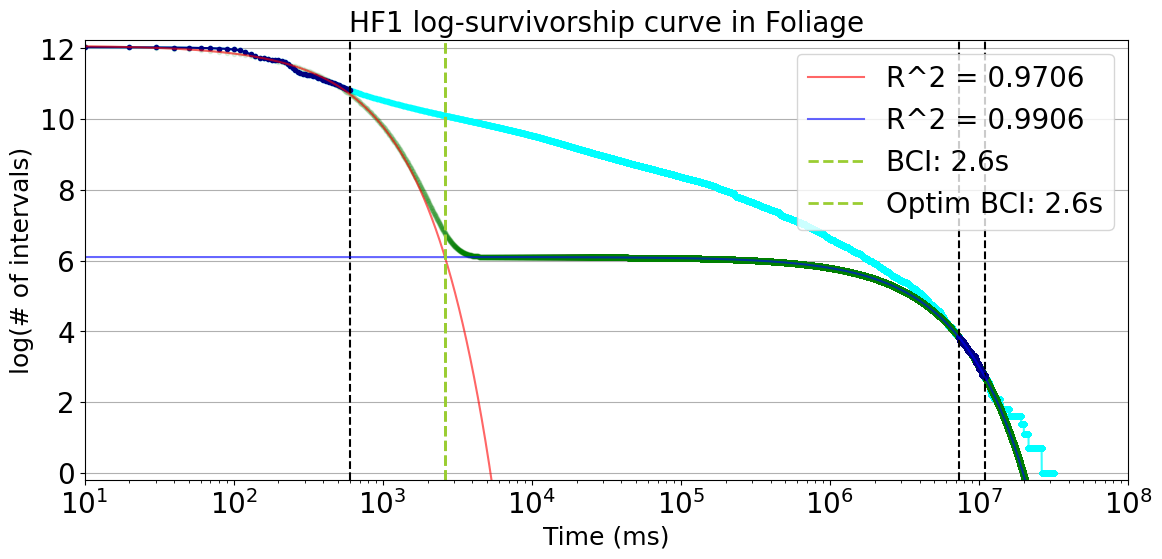

In [28]:
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], nlin_results['bci'], fig_details)

In [29]:
bout_params = bt_clustering.get_bout_params_from_location(location_sum_df, data_params)
bout_params

{'site_key': 'Foliage', 'LF1_bci': 2602.71005605942}

In [30]:
batdetect2_predictions = bt_clustering.classify_bouts_in_bd2_predictions_for_freqgroups(location_sum_df, bout_params)
batdetect2_predictions[:15]

call_status  change_markers  bout_tag  duration_from_last_call_ms  \
0   outside bout             0.0         0                2.602710e+03   
1     bout start             1.0         0                4.138298e+06   
2    within bout             0.0         1                1.431600e+03   
3       bout end            -1.0         1                4.587000e+02   
4     bout start             1.0         0                4.085380e+04   
5    within bout             0.0         1                1.058100e+03   
6    within bout             0.0         1                2.428000e+02   
7    within bout             0.0         1                1.571000e+02   
8    within bout             0.0         1                2.474000e+02   
9    within bout             0.0         1                4.310000e+02   
10   within bout             0.0         1                1.552000e+02   
11   within bout             0.0         1                2.338000e+02   
12   within bout             0.0         1                1.382000e+02   
13   within bout             0.0         1                1.649000e+02   
14   within bout             0.0         1                1.413000e+02   

    start_time_wrt_ref  end_time_wrt_ref freq_group            ref_time  \
0             204.4695          204.4856        LF1 2022-06-15 03:30:00   
1             742.7835          742.7999        LF1 2022-06-15 04:30:00   
2             744.2315          744.2468        LF1 2022-06-15 04:30:00   
3             744.7055          744.7217        LF1 2022-06-15 04:30:00   
4             785.5755          785.5914        LF1 2022-06-15 04:30:00   
5             786.6495          786.6667        LF1 2022-06-15 04:30:00   
6             786.9095          786.9274        LF1 2022-06-15 04:30:00   
7             787.0845          787.1001        LF1 2022-06-15 04:30:00   
8             787.3475          787.3625        LF1 2022-06-15 04:30:00   
9             787.7935          787.8103        LF1 2022-06-15 04:30:00   
10            787.9655          787.9807        LF1 2022-06-15 04:30:00   
11            788.2145          788.2313        LF1 2022-06-15 04:30:00   
12            788.3695          788.3826        LF1 2022-06-15 04:30:00   
13            788.5475          788.5602        LF1 2022-06-15 04:30:00   
14            788.7015          788.7130        LF1 2022-06-15 04:30:00   

              call_start_time              call_end_time  ...  high_freq  \
0  2022-06-15 03:33:24.469500 2022-06-15 03:33:24.485600  ...    23399.0   
1  2022-06-15 04:42:22.783500 2022-06-15 04:42:22.799900  ...    26704.0   
2  2022-06-15 04:42:24.231500 2022-06-15 04:42:24.246800  ...    28244.0   
3  2022-06-15 04:42:24.705500 2022-06-15 04:42:24.721700  ...    28061.0   
4  2022-06-15 04:43:05.575500 2022-06-15 04:43:05.591400  ...    29948.0   
5  2022-06-15 04:43:06.649500 2022-06-15 04:43:06.666700  ...    29172.0   
6  2022-06-15 04:43:06.909500 2022-06-15 04:43:06.927400  ...    29777.0   
7  2022-06-15 04:43:07.084500 2022-06-15 04:43:07.100100  ...    32867.0   
8  2022-06-15 04:43:07.347500 2022-06-15 04:43:07.362500  ...    30586.0   
9  2022-06-15 04:43:07.793500 2022-06-15 04:43:07.810300  ...    32800.0   
10 2022-06-15 04:43:07.965500 2022-06-15 04:43:07.980700  ...    34462.0   
11 2022-06-15 04:43:08.214500 2022-06-15 04:43:08.231300  ...    33030.0   
12 2022-06-15 04:43:08.369500 2022-06-15 04:43:08.382600  ...    36097.0   
13 2022-06-15 04:43:08.547500 2022-06-15 04:43:08.560200  ...    36823.0   
14 2022-06-15 04:43:08.701500 2022-06-15 04:43:08.713000  ...    36871.0   

           event                class  class_prob det_prob individual  \
0   Echolocation     Nyctalus noctula       0.399    0.544         -1   
1   Echolocation    Nyctalus leisleri       0.520    0.600         -1   
2   Echolocation    Nyctalus leisleri       0.555    0.660         -1   
3   Echolocation    Nyctalus leisleri       0.471    0.601         -1   
4   Echolocation    Nyctalus leisleri

In [31]:
bout_metrics = bt_clustering.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_predictions)

time_on = int(dc_tag.split('of')[0])

bt_clustering.test_bout_end_times_in_period(bout_metrics, time_on)

In [32]:
bout_metrics

freq_group            start_time_of_bout           end_time_of_bout  \
0            LF1 2022-06-15 04:42:22.783500000 2022-06-15 04:42:24.721700   
1            LF1 2022-06-15 04:43:05.575500000 2022-06-15 04:43:22.591800   
2            LF1 2022-06-15 04:44:55.963500000 2022-06-15 04:44:56.323100   
3            LF1 2022-06-15 04:45:50.506499999 2022-06-15 04:45:53.863000   
4            LF1 2022-06-15 04:45:57.825500000 2022-06-15 04:46:13.752300   
...          ...                           ...                        ...   
14608        LF1 2022-10-17 05:55:12.176500000 2022-10-17 05:55:19.583000   
14609        LF1 2022-10-17 06:10:00.661500000 2022-10-17 06:10:09.401100   
14610        LF1 2022-10-17 06:20:43.780500000 2022-10-17 06:20:49.474300   
14611        LF1 2022-10-17 06:42:30.291500000 2022-10-17 06:42:35.001500   
14612        LF1 2022-10-17 08:00:47.378500000 2022-10-17 08:00:52.263500   

       start_time_wrt_ref  end_time_wrt_ref  start_time   end_time  low_freq  \
0                742.7835          744.7217    742.7835   744.7217   22890.0   
1                785.5755          802.5918    785.5755   802.5918   23750.0   
2                895.9635          896.3231    895.9635   896.3231   24609.0   
3                950.5065          953.8630    950.5065   953.8630   25468.0   
4                957.8255          973.7523    957.8255   973.7523   23750.0   
...                   ...               ...         ...        ...       ...   
14608           1512.1765         1519.5830   1512.1765  1519.5830   25468.0   
14609            600.6615          609.4011    600.6615   609.4011   25468.0   
14610           1243.7805         1249.4743   1243.7805  1249.4743   26328.0   
14611            750.2915          755.0015    750.2915   755.0015   25468.0   
14612             47.3785           52.2635     47.3785    52.2635   24609.0   

       high_freq             bout_duration  bout_duration_in_secs  
0        28244.0    0 days 00:00:01.938200                 1.9382  
1        49983.0    0 days 00:00:17.016300                17.0163  
2        30259.0    0 days 00:00:00.359600                 0.3596  
3        36167.0 0 days 00:00:03.356500001                 3.3565  
4        48849.0    0 days 00:00:15.926800                15.9268  
...          ...                       ...                    ...  
14608    34634.0    0 days 00:00:07.406500                 7.4065  
14609    34996.0    0 days 00:00:08.739600                 8.7396  
14610    34586.0    0 days 00:00:05.693800                 5.6938  
14611    30527.0    0 days 00:00:04.710000                 4.7100  
14612    31237.0    0 days 00:00:04.885000                 4.8850  

[14613 rows x 11 columns]

In [33]:
bout_metrics = bt_clustering.generate_bout_metrics_for_location_and_freq(location_df, data_params, dc_tag)
bout_metrics

freq_group            start_time_of_bout           end_time_of_bout  \
0            LF1 2022-06-15 04:42:22.783500000 2022-06-15 04:42:24.721700   
1            LF1 2022-06-15 04:43:05.575500000 2022-06-15 04:43:22.591800   
2            LF1 2022-06-15 04:44:55.963500000 2022-06-15 04:44:56.323100   
3            LF1 2022-06-15 04:45:50.506499999 2022-06-15 04:45:53.863000   
4            LF1 2022-06-15 04:45:57.825500000 2022-06-15 04:46:13.752300   
...          ...                           ...                        ...   
14608        LF1 2022-10-17 05:55:12.176500000 2022-10-17 05:55:19.583000   
14609        LF1 2022-10-17 06:10:00.661500000 2022-10-17 06:10:09.401100   
14610        LF1 2022-10-17 06:20:43.780500000 2022-10-17 06:20:49.474300   
14611        LF1 2022-10-17 06:42:30.291500000 2022-10-17 06:42:35.001500   
14612        LF1 2022-10-17 08:00:47.378500000 2022-10-17 08:00:52.263500   

       start_time_wrt_ref  end_time_wrt_ref  start_time   end_time  low_freq  \
0                742.7835          744.7217    742.7835   744.7217   22890.0   
1                785.5755          802.5918    785.5755   802.5918   23750.0   
2                895.9635          896.3231    895.9635   896.3231   24609.0   
3                950.5065          953.8630    950.5065   953.8630   25468.0   
4                957.8255          973.7523    957.8255   973.7523   23750.0   
...                   ...               ...         ...        ...       ...   
14608           1512.1765         1519.5830   1512.1765  1519.5830   25468.0   
14609            600.6615          609.4011    600.6615   609.4011   25468.0   
14610           1243.7805         1249.4743   1243.7805  1249.4743   26328.0   
14611            750.2915          755.0015    750.2915   755.0015   25468.0   
14612             47.3785           52.2635     47.3785    52.2635   24609.0   

       high_freq             bout_duration  bout_duration_in_secs  
0        28244.0    0 days 00:00:01.938200                 1.9382  
1        49983.0    0 days 00:00:17.016300                17.0163  
2        30259.0    0 days 00:00:00.359600                 0.3596  
3        36167.0 0 days 00:00:03.356500001                 3.3565  
4        48849.0    0 days 00:00:15.926800                15.9268  
...          ...                       ...                    ...  
14608    34634.0    0 days 00:00:07.406500                 7.4065  
14609    34996.0    0 days 00:00:08.739600                 8.7396  
14610    34586.0    0 days 00:00:05.693800                 5.6938  
14611    30527.0    0 days 00:00:04.710000                 4.7100  
14612    31237.0    0 days 00:00:04.885000                 4.8850  

[14613 rows x 11 columns]

In [34]:
dc_bouts = dh.construct_activity_arr_from_bout_metrics(bout_metrics, data_params, file_paths, dc_tag)
dc_bouts = dc_bouts.set_index("Date_and_Time_UTC")

In [35]:
activity_bouts_arr = pipeline.run_for_bouts(data_params, pipeline_params, file_paths)

In [36]:
activity_bouts_arr[-23:]

percentage_time_occupied_by_bouts (1800of1800)  \
Date_and_Time_UTC                                                     
2022-10-17 02:00:00                                         11.7671   
2022-10-17 02:30:00                                          0.0000   
2022-10-17 03:00:00                                          7.0225   
2022-10-17 03:30:00                                         19.3960   
2022-10-17 04:00:00                                         14.3321   
2022-10-17 04:30:00                                          8.1468   
2022-10-17 05:00:00                                          7.0254   
2022-10-17 05:30:00                                         18.2048   
2022-10-17 06:00:00                                         14.4334   
2022-10-17 06:30:00                                          4.7100   
2022-10-17 07:00:00                                          0.0000   
2022-10-17 07:30:00                                          0.0000   
2022-10-17 08:00:00                                          4.8850   
2022-10-17 08:30:00                                          0.0000   
2022-10-17 09:00:00                                          0.0000   
2022-10-17 09:30:00                                          0.0000   
2022-10-17 10:00:00                                          0.0000   
2022-10-17 10:30:00                                          0.0000   
2022-10-17 11:00:00                                          0.0000   
2022-10-17 11:30:00                                          0.0000   
2022-10-17 12:00:00                                          0.0000   
2022-10-17 12:30:00                                          0.0000   
2022-10-17 13:00:00                                          0.0000   

                     percentage_time_occupied_by_bouts (300of1800)  \
Date_and_Time_UTC                                                    
2022-10-17 02:00:00                                         0.0000   
2022-10-17 02:30:00                                         0.0000   
2022-10-17 03:00:00                                         0.0000   
2022-10-17 03:30:00                                        11.6887   
2022-10-17 04:00:00                                         5.3298   
2022-10-17 04:30:00                                         0.0000   
2022-10-17 05:00:00                                         0.0000   
2022-10-17 05:30:00                                         0.0000   
2022-10-17 06:00:00                                         0.0000   
2022-10-17 06:30:00                                         0.0000   
2022-10-17 07:00:00                                         0.0000   
2022-10-17 07:30:00                                         0.0000   
2022-10-17 08:00:00                                         4.8850   
2022-10-17 08:30:00                                         0.0000   
2022-10-17 09:00:00                                         0.0000   
2022-10-17 09:30:00                                         0.0000   
2022-10-17 10:00:00                                         0.0000   
2022-10-17 10:30:00                                         0.0000   
2022-10-17 11:00:00                                         0.0000   
2022-10-17 11:30:00                                         0.0000   
2022-10-17 12:00:00                                         0.0000   
2022-10-17 12:30:00                                         0.0000   
2022-10-17 13:00:00                                         0.0000   

                     percentage_time_occupied_by_bouts (60of360)  
Date_and_Time_UTC                                                 
2022-10-17 02:00:00                                       5.6518  
2022-10-17 02:30:00                                       0.0000  
2022-10-17 03:00:00                                       0.0000  
2022-10-17 03:30:00                                       8.6666  
2022-10-17 04:00:00                                       0.0000  
2022-10-17 04:30:00      

In [37]:
plotting.plot_activity_grid_for_bouts(dh.construct_activity_grid_for_bouts(activity_bouts_arr, data_params['cur_dc_tag']), data_params, pipeline_params, file_paths)
# plotting.plot_dc_bouts_comparisons_per_night(activity_bouts_arr, data_params, pipeline_params, file_paths)

In [38]:
plotting.plot_dc_bout_activity_comparisons_per_scheme(activity_bouts_arr, data_params, pipeline_params, file_paths)

In [ ]:
# pipeline.plot_bouts(activity_bouts_arr, data_params, pipeline_params, file_paths)

In [ ]:
# pipeline.compare_bout_and_det_metrics(data_params, pipeline_params, file_paths)